# import libraries

In [1]:
import pandas as pd
import numpy as np
from datasist.structdata import detect_outliers

from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import itertools
import warnings
warnings.filterwarnings('ignore')

# implement necessary function to help us

In [2]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def MLPredictAcc(X, y, classes , scale = False , smote = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if (smote == True):
        sampler = SMOTE()
        X_train, y_train = sampler.fit_resample(X_train, y_train)
    if (scale == True) :
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    models = {
        "XGB": XGBClassifier(),
        "KNN": KNeighborsClassifier(),
        "SVC": SVC(),
        "DT": DecisionTreeClassifier(),
        "RF": RandomForestClassifier(),
        "GaussianNB" : GaussianNB(),
        "Perceptron" : Perceptron(),
        "LinearSVC" : LinearSVC(),
        "SGDClassifier" : SGDClassifier(),
        "LogisticRegression" : LogisticRegression()
    }
    modell = []
    modell_acc = []
    model_built = {}
    for name, model in models.items():
        print(f'Training Model {name} \n--------------')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cf = confusion_matrix(y_test, y_pred)
        acc_svc = round(accuracy_score(y_test, y_pred) * 100,2)
        modell.append(name)
        modell_acc.append(acc_svc)
        model_built[name]=model
        plot_confusion_matrix(cf, classes, title='{} cf with acc = {} %'.format(name,acc_svc))
        print('-' * 30)
    models = pd.DataFrame(
        {
            'Model': modell,
            'Score': modell_acc ,

        })
    models = models.sort_values(by='Score', ascending=False)
    models['Score'] = models['Score'].apply(lambda x : str(x) + " %")
    modelss = pd.DataFrame({
        "index ": [p for p in range(1,len(modell_acc)+1)],
         "model" : models['Model'],
         'Score': models['Score'],
    })

    if (scale == True):
        return modelss, model_built , scaler
    else:
        return modelss, model_built


In [4]:
def define_column_type(df):
    numerical_column =  df.select_dtypes(exclude='O').columns.to_list()
    categorical_column = df.select_dtypes(include='O').columns.to_list()
    return numerical_column , categorical_column

In [5]:
def show_value_count_category_column(df ):
    for name in define_column_type(df)[1]:
        df_count = pd.DataFrame(df[name].value_counts())
        print(df_count)
        print("*" * 50)

In [6]:
def visualize_null_count(df):
    plt.figure(figsize=(12,8))
    print(df.isnull().sum())
    sns.heatmap(df.isnull())


In [7]:
def make_encoding_dict(df):
    return dict(tuple(zip(df.value_counts().index.tolist(), [i for i in range (100)])))

In [8]:
def detect_outlier(df,numerical):
    for col in numerical:
        outliers = detect_outliers(df, 0, [col])
        df.drop(outliers, inplace=True)
        print("len outliner in {} = {}".format(col,len(outliers)) )

In [9]:
def fill_missing_numerical_data(df_rows_values):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(df_rows_values)
    df_rows_values = imputer.transform(df_rows_values)
    return df_rows_values

In [10]:
def EncodingIndependentVariable(df_rows_values):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
    df_rows_values = np.array(ct.fit_transform(df_rows_values))
    return  df_rows_values , ct

In [11]:
def EncodingDependentVariable(y_values):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_values = le.fit_transform(y_values)
    return y_values , le

In [12]:
def apply_Feature_Scaling(df_train_rows_values,df_test_rows_values):
    sc = StandardScaler()
    df_train_rows_values = sc.fit_transform(df_train_rows_values)
    df_test_rows_values = sc.transform(df_test_rows_values)

# Importing the dataset

In [13]:
df = pd.read_csv("Data.csv")

In [14]:
df

,Country,Age,Salary,Purchased
0,France,44.0,72000.0,No
1,Spain,27.0,48000.0,Yes
2,Germany,30.0,54000.0,No
3,Spain,38.0,61000.0,No
4,Germany,40.0,NaN,Yes
5,France,35.0,58000.0,Yes
6,Spain,NaN,52000.0,No
7,France,48.0,79000.0,Yes
8,Germany,50.0,83000.0,No
9,France,37.0,67000.0,Yes


In [15]:
numeric , catecorical = define_column_type(df)
print("numeric : ",numeric)
print("-------------------------------")
print("catecorical : ",catecorical)

numeric :  ['Age', 'Salary']
-------------------------------
catecorical :  ['Country', 'Purchased']


In [16]:
show_value_count_category_column(df)

         Country
France         4
Spain          3
Germany        3
**************************************************
     Purchased
No           5
Yes          5
**************************************************


Country      0
Age          1
Salary       1
Purchased    0
dtype: int64


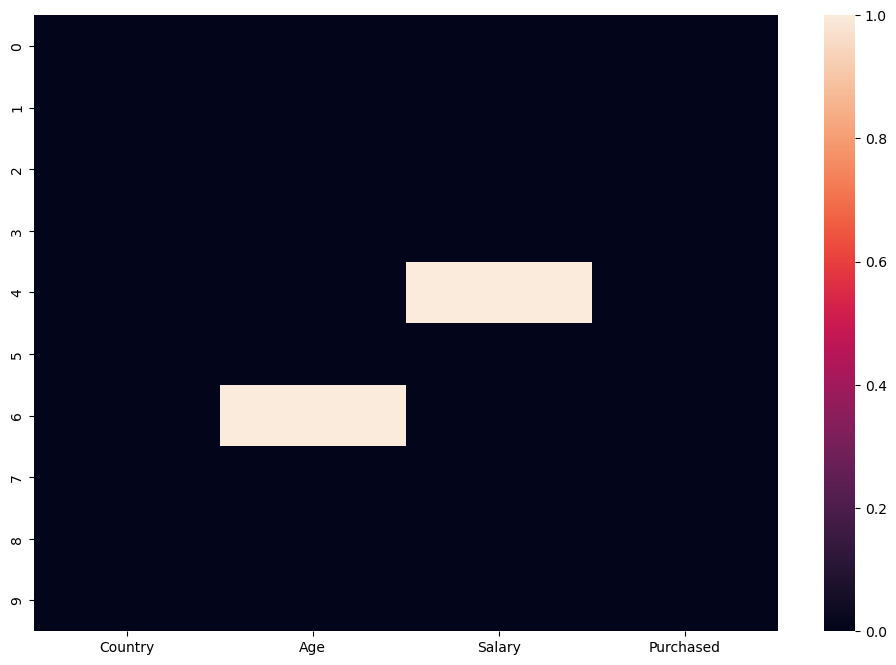

In [17]:
visualize_null_count(df)

In [18]:
make_encoding_dict(df["Country"])

{'France': 0, 'Spain': 1, 'Germany': 2}

In [19]:
detect_outlier(df,numeric)

len outliner in Age = 0
len outliner in Salary = 0


In [20]:
df[numeric] = fill_missing_numerical_data(df[numeric])

In [21]:
df

,Country,Age,Salary,Purchased
0,France,44.000000,72000.000000,No
1,Spain,27.000000,48000.000000,Yes
2,Germany,30.000000,54000.000000,No
3,Spain,38.000000,61000.000000,No
4,Germany,40.000000,63777.777778,Yes
5,France,35.000000,58000.000000,Yes
6,Spain,38.777778,52000.000000,No
7,France,48.000000,79000.000000,Yes
8,Germany,50.000000,83000.000000,No
9,France,37.000000,67000.000000,Yes


In [22]:
datasets = df.values

In [23]:
X , ct = EncodingIndependentVariable(datasets[:,0:-1])
y , yt = EncodingDependentVariable(datasets[:,-1]) 

Training Model XGB 
--------------


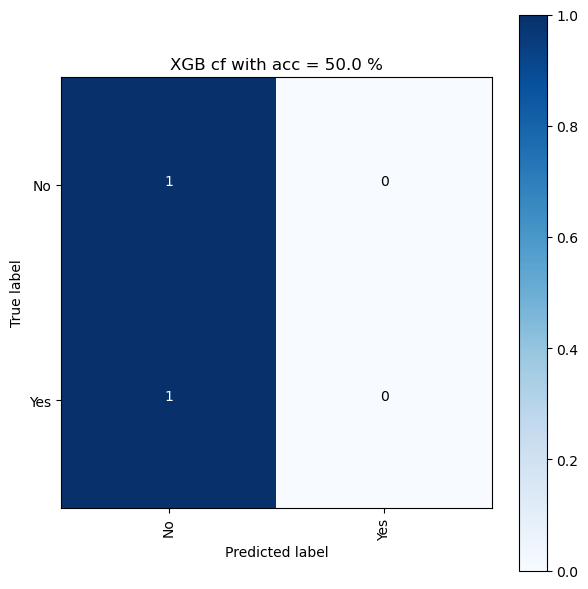

------------------------------
Training Model KNN 
--------------


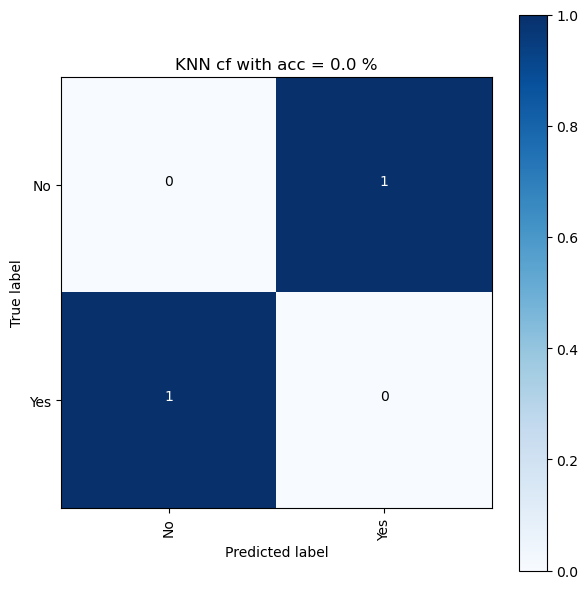

------------------------------
Training Model SVC 
--------------


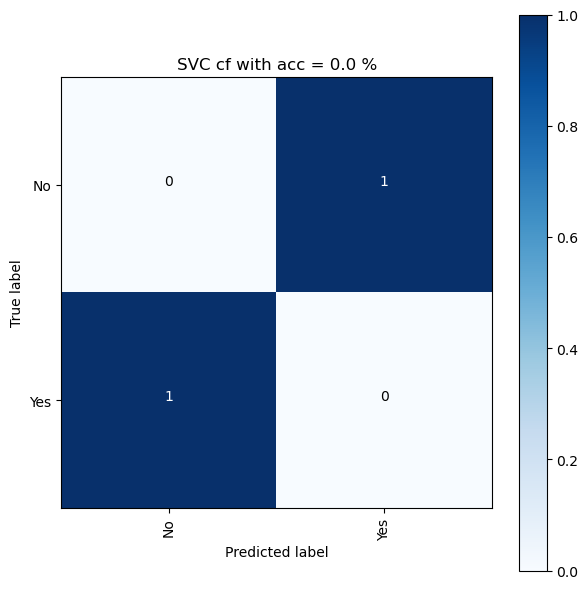

------------------------------
Training Model DT 
--------------


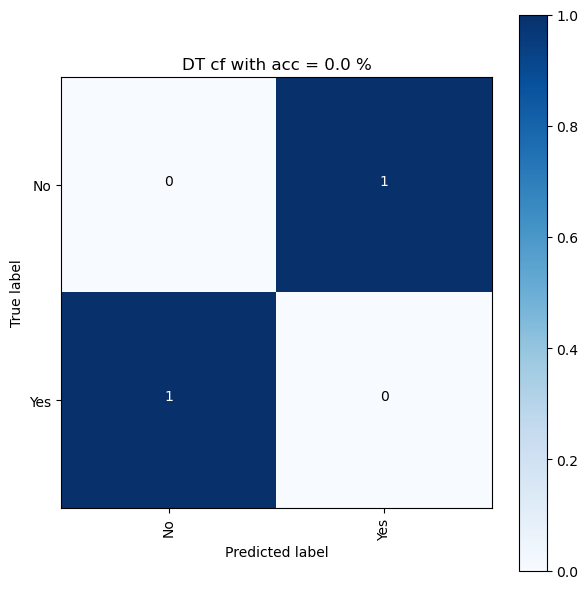

------------------------------
Training Model RF 
--------------


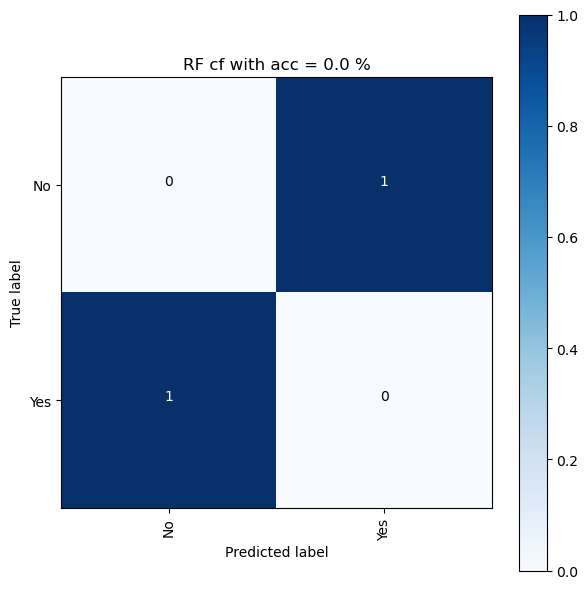

------------------------------
Training Model GaussianNB 
--------------


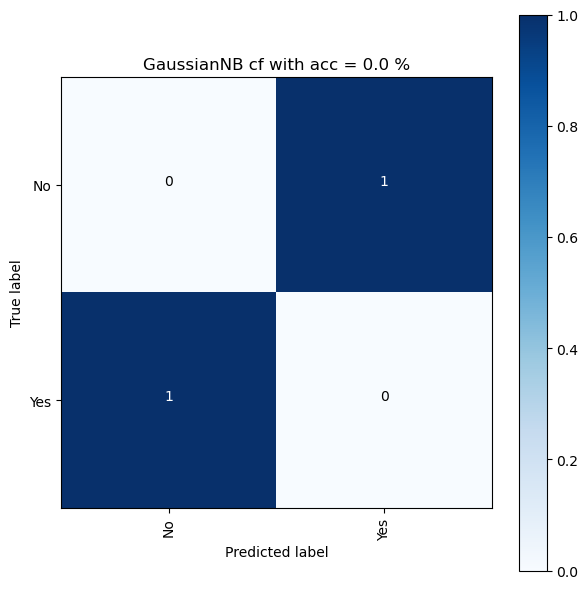

------------------------------
Training Model Perceptron 
--------------


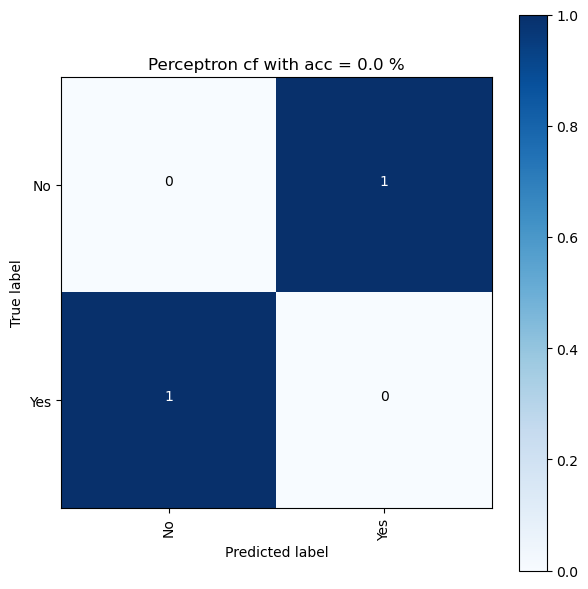

------------------------------
Training Model LinearSVC 
--------------


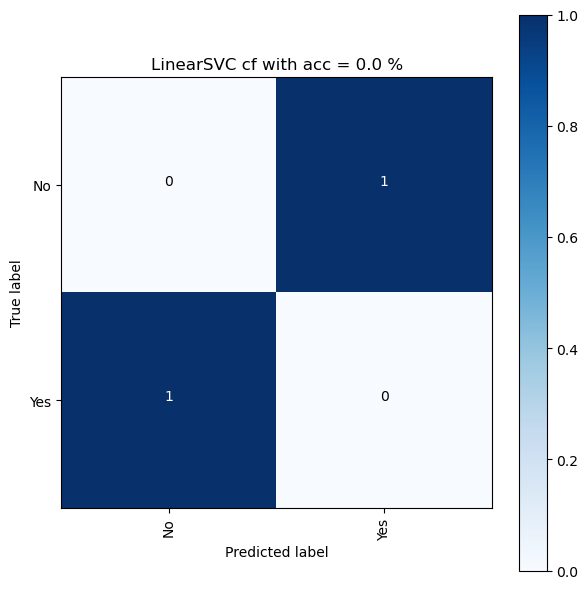

------------------------------
Training Model SGDClassifier 
--------------


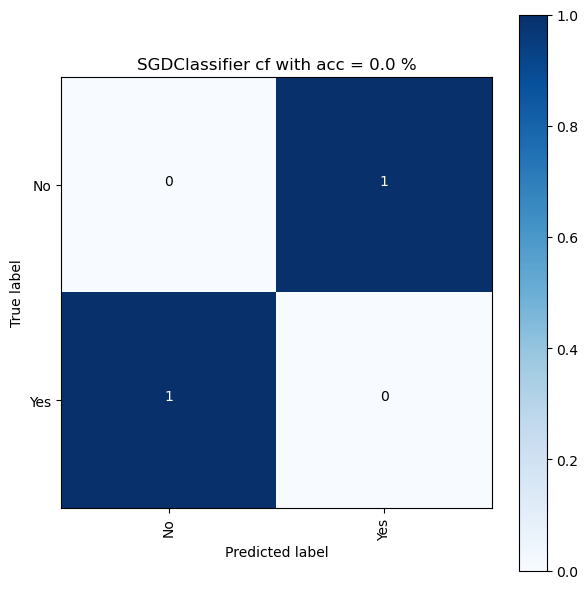

------------------------------
Training Model LogisticRegression 
--------------


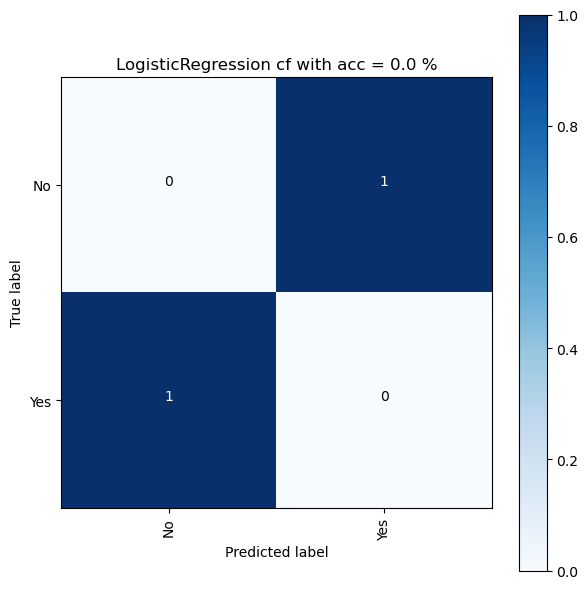

------------------------------


In [24]:
modelss, model_built , scaler = MLPredictAcc(X, y, ["No","Yes"] , scale = True , smote = False)

In [25]:
modelss

,index,model,Score
0,1,XGB,50.0 %
1,2,KNN,0.0 %
2,3,SVC,0.0 %
3,4,DT,0.0 %
4,5,RF,0.0 %
5,6,GaussianNB,0.0 %
6,7,Perceptron,0.0 %
7,8,LinearSVC,0.0 %
8,9,SGDClassifier,0.0 %
9,10,LogisticRegression,0.0 %


In [27]:
X[0]

array([1.0, 0.0, 0.0, 44.0, 72000.0], dtype=object)

In [35]:
model_built["XGB"].predict(scaler.transform(ct.transform([["Spain",38.0,61000]])))

array([0])

In [36]:
ct.transform([["Spain",38.0,61000]])

array([[0.0, 0.0, 1.0, 38.0, 61000]], dtype=object)

In [50]:
print("predict value : " + list(yt.inverse_transform(model_built["XGB"].predict(scaler.transform(ct.transform([["Spain",38.0,61000]])))))[0])

predict value : No
